<a href="https://colab.research.google.com/github/Yash-10/qml-hep/blob/main/qml_hep_tasks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
try:
  import cirq
except:
  print("installing cirq...")
  !pip install --quiet cirq
  print("installed cirq")

In [4]:
import cirq
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

**Task 1**

In [5]:
from cirq.ops import H, CNOT, X
from cirq.ops.swap_gates import SWAP
import math

def cirq_layers():
  qubits = cirq.LineQubit.range(5)
  q0, q1, q2, q3, q4 = qubits
  yield [H(q) for q in qubits] # See .on_each method and try to replace
  yield [CNOT(q0, q1), CNOT(q1, q2), CNOT(q2, q3), CNOT(q3, q4)]
  yield SWAP(q0, q4)
  yield cirq.rx(np.pi / 2).on(q0) # TODO: Fix this line after uncommenting

circuit = cirq.Circuit()
circuit.append(cirq_layers())

print(circuit)

0: ───H───@───────────────×───Rx(0.5π)───
          │               │
1: ───H───X───@───────────┼──────────────
              │           │
2: ───H───────X───@───────┼──────────────
                  │       │
3: ───H───────────X───@───┼──────────────
                      │   │
4: ───H───────────────X───×──────────────


In [6]:
# https://quantumai.google/cirq/tutorials/educators/intro
def circuit_with_rx_rotations():
  q = cirq.NamedQubit('my_qubit')
  circuit = cirq.Circuit([cirq.rx(np.pi / 50.0)(q) for _ in range(200)])
  simulator = cirq.Simulator()
  for step in simulator.simulate_moment_steps(circuit):
    prob = np.abs(step.state_vector()) ** 2
    yield prob[0] # 0 for getting probability in the |0> state

Text(0.5, 1.0, 'Probability to find in |0> state')

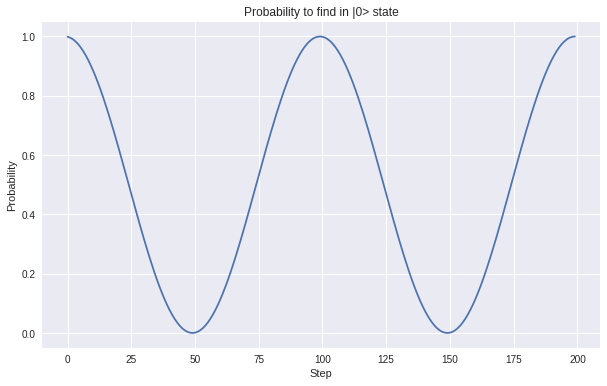

In [7]:
plt.figure(figsize=(10, 6))
plt.style.use('seaborn')
plt.xlabel("Step")
plt.ylabel("Probability")
plt.plot(list(circuit_with_rx_rotations()))
plt.title("Probability to find in |0> state")

**Task 3**

In [8]:
!pip install -q tensorflow==2.3.1

     |████████████████████████████████| 320.4MB 44kB/s 
     |████████████████████████████████| 20.1MB 9.3MB/s 
     |████████████████████████████████| 460kB 54.5MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [9]:
!pip install -q tensorflow-quantum

     |████████████████████████████████| 5.9MB 9.7MB/s 
     |████████████████████████████████| 5.6MB 27.3MB/s 
     |████████████████████████████████| 1.6MB 41.2MB/s 
     |████████████████████████████████| 1.3MB 45.2MB/s 


In [42]:
electron_photon_path = "/content/electron-photon.npz"

with np.load(electron_photon_path, allow_pickle=True) as data:
  x_train, y_train, x_test, y_test = [data[data.files[i]] for i in range(len(data.files))]

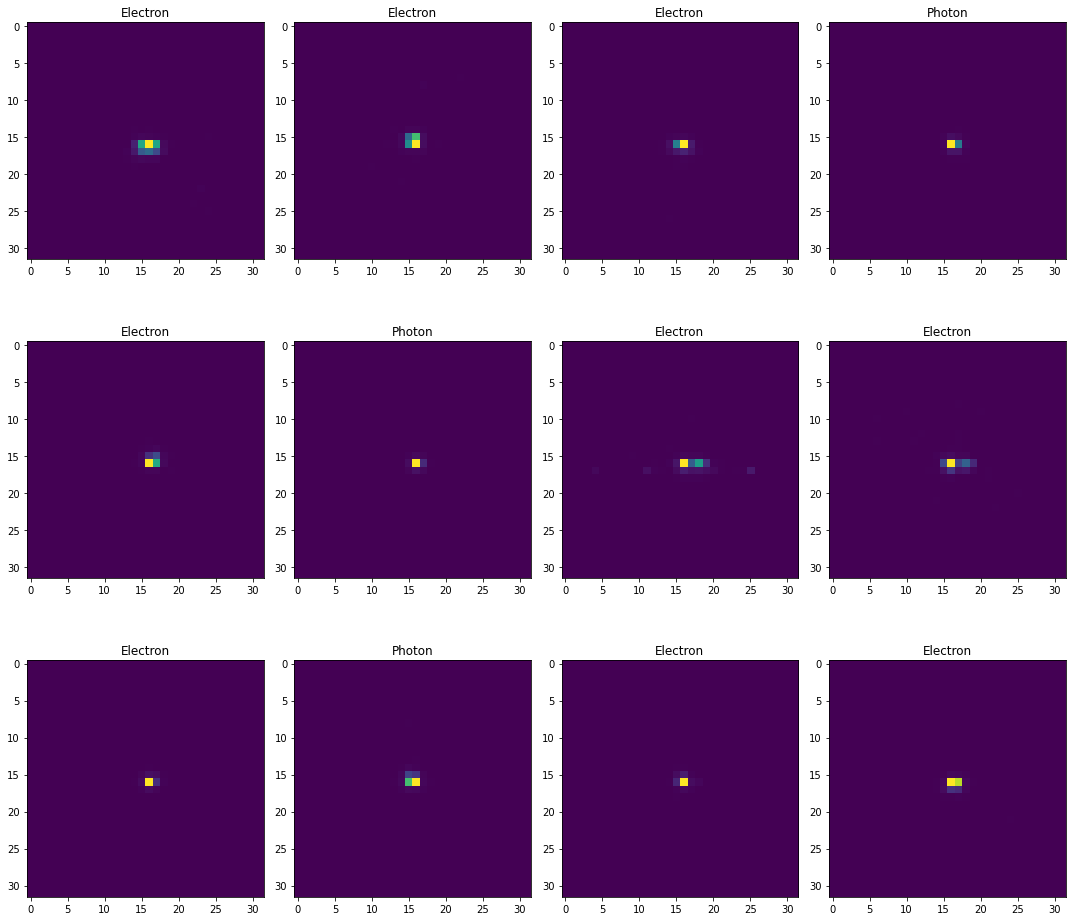

In [43]:
# Show some training samples

def plot_images_train_set(x_train, y_train):
  """
  x_train: A set of training images
  y_train: It's corresponding labels
  """

  fig = plt.figure(figsize=(15, 15))
  nrows = 3
  ncols = 4
  to_show = nrows * ncols
  for i in range(to_show):
    fig.add_subplot(nrows, ncols, i+1)
    plt.imshow(x_train[i])
    plt.title("Photon" if int(y_train[i]) == int(0.0) else "Electron")
    plt.tight_layout()
plot_images_train_set(x_train, y_train)

As seen from the above plots, the region of interest is small compared to the size of image (32 * 32). Hence downscaling the images. It would also allow to keep computational costs for the quantum network under limit.


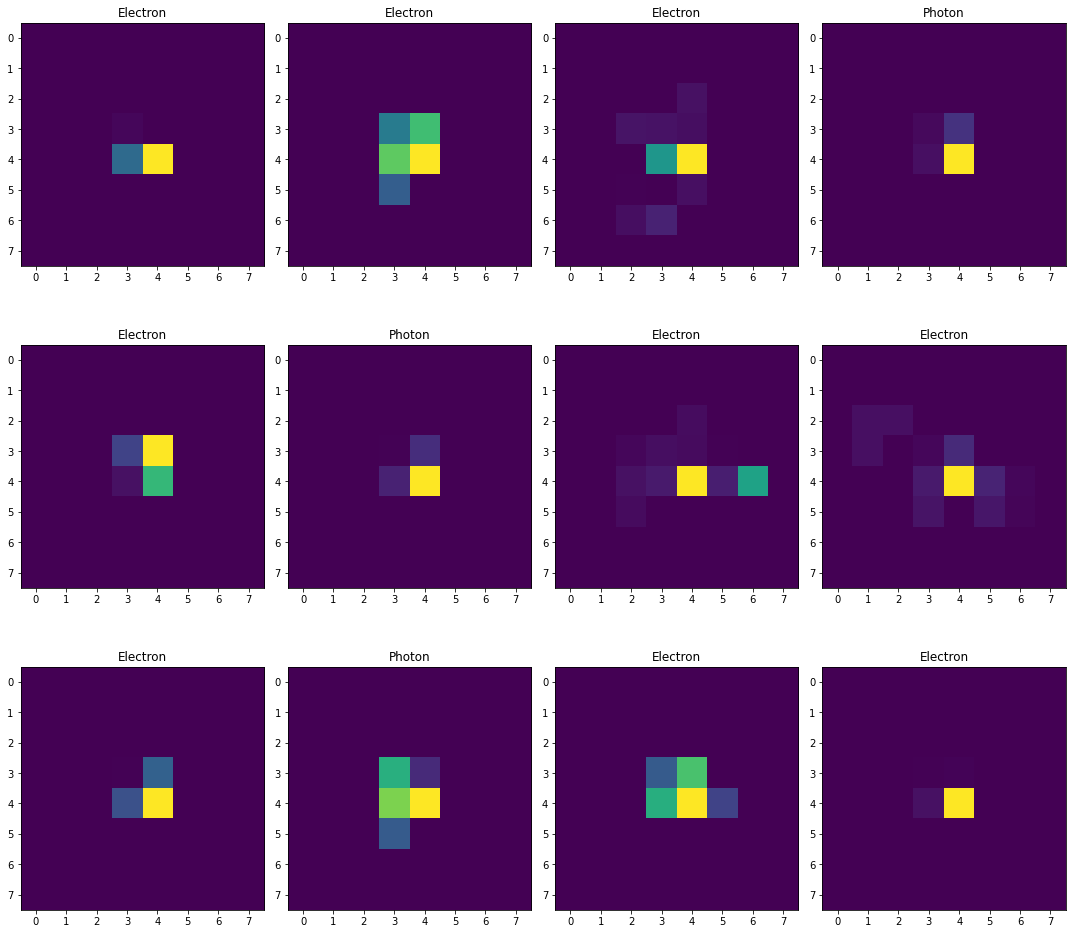

In [44]:
expand_x_train = x_train[..., np.newaxis]
expand_x_test = x_test[..., np.newaxis]

x_train_new = tf.image.resize(expand_x_train, (8, 8)).numpy()
x_test_new = tf.image.resize(expand_x_test, (8, 8)).numpy()

plot_images_train_set(x_train_new[..., -1], y_train)

References: \
1. https://pennylane.ai/qml/demos/tutorial_quanvolution.html

In [ ]:
!pip install pennylane

     |████████████████████████████████| 409kB 7.9MB/s 
  Created wheel for pennylane: filename=PennyLane-0.14.1-cp37-none-any.whl size=481980 sha256=b9c9f2a4416409346e7316aea54204249ccb05d4797ee9228d60414b9629dd49
  Stored in directory: /root/.cache/pip/wheels/6e/a9/c9/04941d6dd58b3c111cbd1389bf63ba1b23362c137359af4626
Successfully built pennylane


In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [ ]:
n_epochs = 5   # Number of optimization epochs
n_layers = 3    # Number of random layers
n_train = len(x_train_new)    # Size of the train dataset
n_test = len(x_test_new)     # Size of the test dataset

SAVE_PATH = "quanvolution/" # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

In [ ]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

In [ ]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((6, 6, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 8, 2):
        for k in range(0, 8, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

In [ ]:
import os

In [ ]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(x_train_new):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(x_test_new):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    if not os.path.exists(SAVE_PATH):
      os.mkdir(SAVE_PATH)

    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:

Quantum pre-processing of test images:


In [ ]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Flatten(),
        keras.layers.Dense(2, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [ ]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    y_train,
    validation_data=(q_test_images, y_test),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/5
25/25 - 0s - loss: 0.7022 - accuracy: 0.5600 - val_loss: 0.7092 - val_accuracy: 0.4600
Epoch 2/5
25/25 - 0s - loss: 0.6927 - accuracy: 0.5600 - val_loss: 0.7122 - val_accuracy: 0.4600
Epoch 3/5
25/25 - 0s - loss: 0.6928 - accuracy: 0.5600 - val_loss: 0.7077 - val_accuracy: 0.4600
Epoch 4/5
25/25 - 0s - loss: 0.6912 - accuracy: 0.5600 - val_loss: 0.7057 - val_accuracy: 0.4600
Epoch 5/5
25/25 - 0s - loss: 0.6903 - accuracy: 0.5600 - val_loss: 0.7196 - val_accuracy: 0.4600


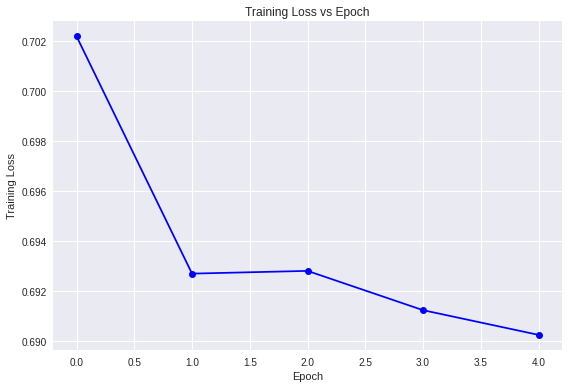

In [ ]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
plt.plot(q_history.history["loss"], "-ob", label="With quantum layer")
plt.title("Training Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.tight_layout()

**Task 4**

References:
1. https://pytorch-geometric.readthedocs.io/en/latest/index.html

In [1]:
!pip install energyflow

In [8]:
import energyflow

In [35]:
energyflow.qg_jets.load(num_data=1, pad=True, ncol=4, generator='pythia',
                        with_bc=False, cache_dir='/content/raw/') # num_data = -1 to download all files

(array([[[ 2.68769142e-01,  3.56903171e-01,  4.74138734e+00,
           2.20000000e+01],
         [ 1.60076377e-01, -2.55609533e-01,  4.55022910e+00,
           2.20000000e+01],
         [ 1.14868731e+00, -6.24380156e-02,  4.50385377e+00,
          -2.11000000e+02],
         [ 4.13159146e+00,  1.73686350e-01,  4.76622410e+00,
          -3.21000000e+02],
         [ 1.69599701e+00, -2.12177764e-01,  4.79687162e+00,
          -2.11000000e+02],
         [ 2.19372581e+00, -5.24780791e-02,  4.57559636e+00,
           2.20000000e+01],
         [ 1.61909680e+00, -6.76247614e-02,  4.64561192e+00,
           2.20000000e+01],
         [ 6.59214883e+00,  4.42691311e-02,  4.76597141e+00,
           2.11000000e+02],
         [ 3.77096258e+00,  4.22475280e-02,  4.75473207e+00,
           3.21000000e+02],
         [ 1.34816345e+01, -2.80005472e-02,  4.73543183e+00,
          -2.11000000e+02],
         [ 4.10794493e+00, -2.37648715e-02,  4.75891312e+00,
           2.20000000e+01],
         [ 2.16455176

In [1]:
# Install required packages.
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-geometric

     |████████████████████████████████| 2.6MB 6.1MB/s 
     |████████████████████████████████| 1.5MB 6.7MB/s 
     |████████████████████████████████| 194kB 8.0MB/s 
     |████████████████████████████████| 235kB 13.8MB/s 
     |████████████████████████████████| 2.2MB 16.6MB/s 
     |████████████████████████████████| 51kB 7.1MB/s 


In [9]:
import numpy as np
import matplotlib.pyplot as plt

In [11]:
with np.load("/content/raw/QG_jets.npz") as raw_data:
  datax = raw_data['X']
  datay = raw_data['y']

In [34]:
from torch_geometric.data import Data, Dataset
import torch
import os

In [28]:
datax_ = Data(datax)
datay_ = Data(datay)

In [35]:
torch.save(datax_, os.path.join("processed/", "data1.pt"))

In [83]:
data__ = torch.load(os.path.join("processed/", "data1.pt"))

In [84]:
data__

Data(x=[[[ 2.68769142e-01  3.56903171e-01  4.74138734e+00  2.20000000e+01]
  [ 1.60076377e-01 -2.55609533e-01  4.55022910e+00  2.20000000e+01]
  [ 1.14868731e+00 -6.24380156e-02  4.50385377e+00 -2.11000000e+02]
  ...
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]

 [[ 1.21266321e+00 -1.12853089e-01  3.04708757e+00 -2.11000000e+02]
  [ 2.40893976e-01 -1.67174886e-02  2.82705667e+00  2.20000000e+01]
  [ 1.02778452e-01 -8.58720522e-02  3.04180579e+00  2.20000000e+01]
  ...
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]

 [[ 2.16829416e-01 -9.97057017e-01  5.32568913e-01  2.20000000e+01]
  [ 2.31359397e-01 -1.59192211e+00  2.02906587e-01  2.20000000e+01]
  [ 3.41572501e-01 -1.345

In [85]:
import os.path as osp

import torch
from torch_geometric.data import Dataset


class QuarkGluonDataset(Dataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(QuarkGluonDataset, self).__init__(root, transform, pre_transform)

    @property
    def processed_file_names(self):
        return ['data_1.pt']

    def process(self):
        i = 0
        for raw_path in self.raw_paths:
            # Read data from `raw_path`.
            data = Data(torch.from_numpy(np.hstack((datax, datay))))

            if self.pre_filter is not None and not self.pre_filter(data):
                continue

            if self.pre_transform is not None:
                data = self.pre_transform(data)

            torch.save(data, osp.join(self.processed_dir, 'data_{}.pt'.format(i)))
            i += 1

    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        data = torch.load(osp.join(self.processed_dir, 'data_{}.pt'.format(idx)))
        return data

In [86]:
dataset = QuarkGluonDataset("/content/")
dataset

QuarkGluonDataset(1)

In [96]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(100, 16)
        self.conv2 = GCNConv(16, 2)

    def forward(self, data):
        data = Data(torch.from_numpy(np.array(data)))
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [102]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

TypeError: ignored

In [103]:
model

Net(
  (conv1): GCNConv(100, 16)
  (conv2): GCNConv(16, 2)
)

In [73]:
# model.eval()
# _, pred = model(data).max(dim=1)
# correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
# acc = correct / int(data.test_mask.sum())
# print('Accuracy: {:.4f}'.format(acc))

Architectures that can be explored:
- PointNet++
- GCNN

**Task 5** \

Quantum technologies are currently explored on a massive scale. Computation in the quantum paradigm allows us to leverage superposition and interference properties, leading to an exponential benefit in terms of computation time and accuracy for solving the otherwise intensive tasks. \
\
Simon's algorithm demonstrates an illustration of this computational benefit. It states that the solution to finding a particular constant, `a` (where `a` is a constant n-bit number), such that a mathematical equation: $f(x XOR a) = f(x)$ is satisfied, follows a linear complexity. The classical solution, on the other hand, scales exponentially with respect to `n.` \
\
This algorithm, along with many such quantum algorithms like the Deutsch-Jozsa algorithm, has showcased quantum technologies' power and opens a whole range of solutions to historical issues of interest, e.g., handling big data and querying them faster. \
\
One immediate consequence of using quantum computing in artificial intelligence is giving machines the ability to learn data efficiently and potentially yield better performance than classical machine learning models. If used appropriately, they could assist in high-performance parallel computing, potentially allowing us to discard training giant neural networks on GPUs or TPUs. \
\
It would be an excellent opportunity to research the applications of quantum machine learning in the field of particle physics. The quantum equivalent of the famous classical model analogs might be a good starting point. The assignment had a task to use classical graph networks to classify quark/gluon jets. One idea that might effectively solve classical particle type classification problems (particularly particle jets) is to encode particle data into qubits in the form of an unordered graph data structure. Moreover, they are invariant to the permutation of particles. This unstructured form could allow quantum neural networks to imbibe a great deal of information about the particles' physics and hence result in better performance. \
\
Moreover, quantum convolutional networks might be potential in solving many problems since their classical counterparts are hungry for data and might take considerable time to solve a problem. From my personal experience, training a classical neural network took a lot of time for a massive amount of data. Hence, I am curious about solving similar problems using emerging quantum technology. Apart from this, it might be an excellent chance to simulate a real quantum computer environment (which is not devoid of noise) and thus experiment with various noise models to quantify quantum networks' efficacy in solving real-life problems.
